<h3>Imports

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from AutoClass_pytorch import autoClassImpute, find_hv_genes
from AutoClass_pytorch_withDiseaseClassifier import autoClassImpute as autoClassImpute_DC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

<h3>Load Dataset

<p>As Dataset we use the singleCell-RNA-Sequence-data from the Seattle Alzheimer's Disease Brain Cell Atlas (SEA-AD)

In [5]:
import scanpy as sc
ad = sc.read_h5ad("data/SEAAD_MTG_RNAseq_final-nuclei.2023-05-05.h5ad", backed="r")

import h5py
f = h5py.File("data/SEAAD_MTG_RNAseq_final-nuclei.2023-05-05.h5ad")

obs = pd.DataFrame()
for i in f["obs"].keys():
    #print(i)
    if i not in ["Hispanic", "Race (choice=American Indian", "Race (choice=Black", "__categories"]:
        obs[i] = np.array(f["obs"][i])

'import scanpy as sc\nad = sc.read_h5ad("data/SEAAD_MTG_RNAseq_final-nuclei.2023-05-05.h5ad", backed="r")\n\nimport h5py\nf = h5py.File("data/SEAAD_MTG_RNAseq_final-nuclei.2023-05-05.h5ad")\n\nobs = pd.DataFrame()\nfor i in f["obs"].keys():\n    #print(i)\n    if i not in ["Hispanic", "Race (choice=American Indian", "Race (choice=Black", "__categories"]:\n        obs[i] = np.array(f["obs"][i])'

In [6]:
import anndata

min_genes_per_cell = 200 # Filter out cells with fewer genes than this expressed 
max_genes_per_cell = 6000 # Filter out cells with more genes than this expressed

set_cells = list()
chunk_size = 2000
for chunk, start, end in ad.chunked_X(chunk_size):
    adata = anndata.AnnData(chunk)
    obs = obs[:chunk_size]
    adata.obs = obs
    print(adata.shape)
    sc.pp.filter_cells(adata, min_genes=min_genes_per_cell, inplace=True)
    sc.pp.filter_cells(adata, max_genes=max_genes_per_cell, inplace=True)
    print(adata.shape)
    sc.pp.highly_variable_genes(adata, inplace=True)
    adata = adata[:, adata.var.highly_variable]
    #print(adata[adata.obs["highly_variable"] == True])
    print(adata.shape)
    break
X = adata.X.toarray()
Y = adata.obs["Subclass"] #cell type label
#np.save("test.npy", X)
#np.save("test2.npy", Y)
del ad
#X = np.load("test.npy")
#Y = np.load("test2.npy")
#pred_label = np.load("test3.npy")


unique_class = np.unique(Y)
KK = len(unique_class) 


<h3>Normal Clustering

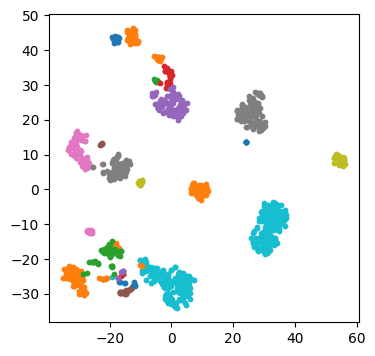

In [100]:
X_norm = take_norm(X)

PCA_raw = PCA(n_components=50).fit_transform(X_norm)
tsne_raw = TSNE(n_components=2).fit_transform(PCA_raw)

fig = plt.figure(figsize=(4,4))
for i in range(KK):
    plt.scatter(tsne_raw[Y==unique_class[i],0],
                tsne_raw[Y==unique_class[i],1], 
                s=10,label = unique_class[i])

<h3>AutoClass - pytorch implementation, without an extra classifier to classify the disease

In [8]:
imp = autoClassImpute(X, num_clusters=KK)

1158 cells and 5614 genes
number of clusters in pre-clustering:[21, 22, 23]
n_cluster = 21...


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


n_cluster = 22...


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


n_cluster = 23...


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


escape time is: 35.12101221084595


Text(0, 0.5, 'tSNE2')

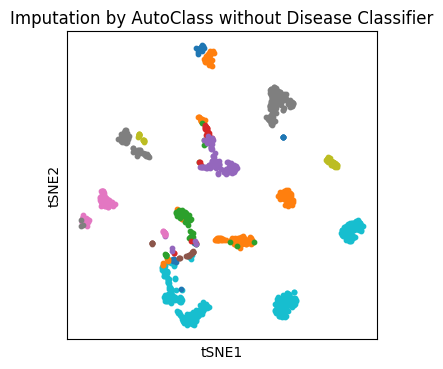

In [11]:
PCA_imp = PCA(n_components=50).fit_transform(imp)
tsne_imp = TSNE(n_components=2).fit_transform(PCA_imp)

fig = plt.figure(figsize=(4,4))
for i in range(KK):
    plt.scatter(tsne_imp[Y==unique_class[i],0],
                tsne_imp[Y==unique_class[i],1], 
                s=10,label = unique_class[i] ) 
plt.title('Imputation by AutoClass without Disease Classifier')
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')

Text(0, 0.5, 'tSNE2')

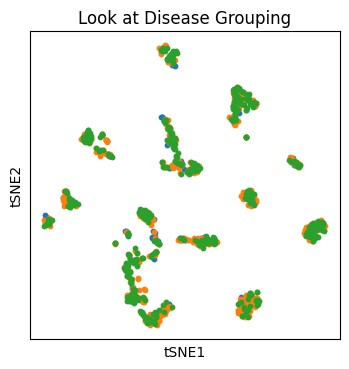

In [12]:
#pred_label = adata.obs["Cognitive Status"]
unique_label = np.unique(pred_label)

fig = plt.figure(figsize=(4,4))
for i in range(len(np.unique(pred_label))):
    plt.scatter(tsne_imp[pred_label==unique_label[i],0],
                tsne_imp[pred_label==unique_label[i],1], 
                s=10,label = unique_label[i])
plt.title('Look at Disease Grouping')
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')

<p> As you can see without the extra disease classifier connected to the bottleneck layer the model does not try to extra seperate the cells within one group in cells with dementia and cells without dementia <p>

<h3>AutoClass - pytorch implementation, with an extra classifier to classify the disease

In [17]:
imp = autoClassImpute_DC(X, np.array(pred_label), num_clusters=KK, classifier_weights=[.1, .8, .1])

1158 cells and 5614 genes
number of clusters in pre-clustering:[21, 22, 23]
n_cluster = 21...


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


n_cluster = 22...


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


n_cluster = 23...


/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


escape time is: 58.21817064285278


Text(0, 0.5, 'tSNE2')

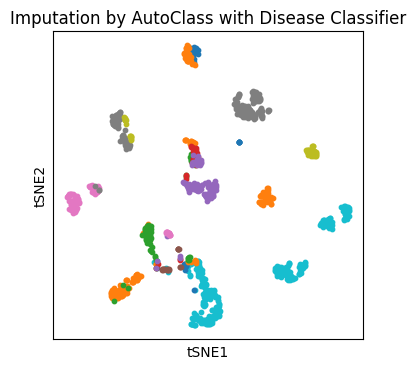

In [21]:
PCA_imp = PCA(n_components=50).fit_transform(imp)
tsne_imp = TSNE(n_components=2).fit_transform(PCA_imp)

fig = plt.figure(figsize=(4,4))
for i in range(KK):
    plt.scatter(tsne_imp[Y==unique_class[i],0],
                tsne_imp[Y==unique_class[i],1], 
                s=10,label = unique_class[i] ) 
plt.title('Imputation by AutoClass with Disease Classifier')
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')

Text(0, 0.5, 'tSNE2')

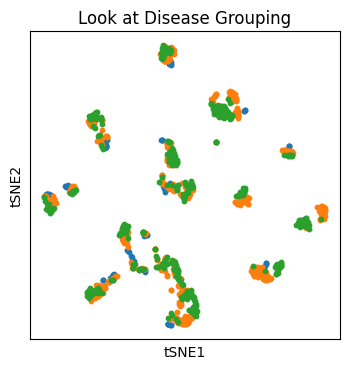

In [22]:
#pred_label = adata.obs["Cognitive Status"]
unique_label = np.unique(pred_label)

fig = plt.figure(figsize=(4,4))
for i in range(len(np.unique(pred_label))):
    plt.scatter(tsne_imp[pred_label==unique_label[i],0],
                tsne_imp[pred_label==unique_label[i],1], 
                s=10,label = unique_label[i])
plt.title('Look at Disease Grouping')
plt.xticks([],[])
plt.yticks([],[])
plt.xlabel('tSNE1')
plt.ylabel('tSNE2')

<p>With the newly introduced classifier, the model still retains the groups as published in the paper i.e. the single-cell RNA-Seq still is being cleaned and in comparission with the normal clustering the batch effect is also still removed <br>
Although the cell groups are clustered in subgroups with and without dementia, which should be mirrored in the cleaned data </p>